# Neural Networks

In [34]:
import warnings

# Ignore UserWarning for QDA
warnings.simplefilter("ignore", UserWarning)

import os

dir = str(os.getcwd())
split_dir = dir.split('\\')

# Set the github repository directory
for folder in reversed(split_dir):
    if folder != 'AA_Project_G6' and 'AA_Project_G6' in split_dir:
        os.chdir(os.path.dirname(os.getcwd()))
    else:
        break

print('Current directory:', os.getcwd())

Current directory: C:\Users\alvar\OneDrive\IST\4º Ano\1º semestre\Automação Avançada\AA_Project_G6


In [35]:
import pandas as pd
import numpy as np

# Import data from .csv file
df = pd.read_csv(filepath_or_buffer='./data/processed/data_processed.csv', delimiter=',')

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
## Divide into input and output
X = df.drop(columns = ["Attrition_Flag_Existing Customer"])
y = df["Attrition_Flag_Existing Customer"]

## Create transformations
transformer_X = MinMaxScaler().fit(X)
X_scaled = transformer_X.transform(X)

## Divide the datasets
seed = 0
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, train_size = 0.7, random_state = seed)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size = 0.66, random_state = seed)

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)

In [38]:
# Determine the number of input features
n_features = X_train.shape[1]

# Define model
model = Sequential()
model.add(Dense(40, activation='relu', input_shape=(n_features,)))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Define the optimizer
model.compile(
    optimizer = Adam(learning_rate=1e-4),
    loss = MeanSquaredError()
)

# Fit the model
history  = model.fit(X_train, y_train, epochs=2000, batch_size=32, verbose=0, validation_data=(X_val, y_val))

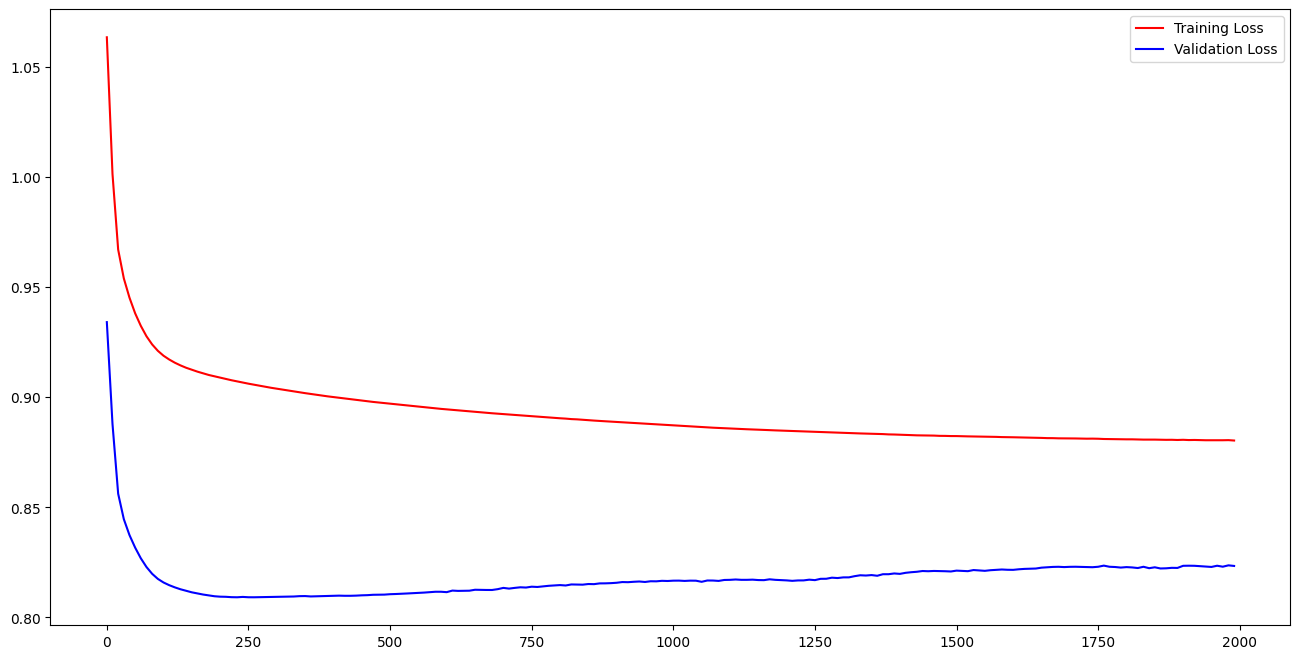

In [14]:
losses = pd.DataFrame(data = {
    'epoch': [(i // 10) * 10 for i in history.epoch],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})
losses = losses.groupby(by = 'epoch').mean().reset_index()

plt.plot(losses.epoch, losses.loss, 'r-', label = 'Training Loss')
plt.plot(losses.epoch, losses.val_loss, 'b-', label = 'Validation Loss')
plt.legend()
plt.show()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1320      
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,161
Trainable params: 2,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
params = [[40, 20, 1e-4, 500, 32],
          [200, 100, 1e-5, 1500, 16],
          [10, 5, 1e-4, 3000, 32],
          [100, 50, 1e-4, 750, 64]]

results_df = pd.DataFrame(columns = ['resid', 'x_axis', 'label'])
losses_df = pd.DataFrame(columns = ['epoch', 'loss', 'val_loss', 'label'])

for i in range(len(params)):
    
    # Print iteration
    print('Iteration {}/{}'.format(i+1, len(params)))
    
    # Define model
    model = Sequential()
    model.add(Dense(params[i][0], activation='relu', input_shape=(n_features,)))
    model.add(Dense(params[i][1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Define the optimizer
    model.compile(
        optimizer = Adam(learning_rate=params[i][2]),
        loss = MeanSquaredError()
    )

    # Fit the model
    history = model.fit(X_train, y_train, epochs=params[i][3], batch_size=params[i][4],
                        verbose=0, validation_data=(X_val, y_val))
    
    # Store the values
    yhat = model.predict(X_test)
    resid = transformer_y.inverse_transform(yhat) - transformer_y.inverse_transform(y_test)
    x_axis = transformer_y.inverse_transform(y_test)
    
    results_df = results_df.append(
        pd.DataFrame(data = {
            'resid': resid.reshape(-1,),
            'x_axis': x_axis.reshape(-1,),
            'label': ','.join([str(j) for j in params[i]])
        })
    )
    
    losses_df = losses_df.append(
        pd.DataFrame(data = {
            'epoch': [(i // 10)*10 for i in history.epoch], 
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'label': ','.join([str(j) for j in params[i]])
        })
    )

In [ ]:
losses = losses_df.groupby(['epoch', 'label']).mean().reset_index().sort_values(by = ['label', 'epoch'])
losses = pd.melt(losses, id_vars = ['epoch', 'label'], value_vars = ['loss', 'val_loss'], var_name = 'test')
losses['label'] = losses['label'] + ' - ' + losses['test']
losses = losses.sort_values(by = ['label', 'epoch'])

labels = losses.label.unique()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
         'tab:purple', 'tab:brown', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots()
for i in range(len(labels)):
    
    idxs = losses.label == labels[i]
    
    ax.plot(
        losses[idxs].epoch, losses[idxs].value, c=colors[i], label=labels[i]
    )

ax.legend()
ax.grid(True)
plt.xlim([-100, 3500])
plt.ylim([losses.value.min()*0.9, losses.value.max()*1.1])

plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score

## Training
y_pred = model.predict(X_train)
print('Training Confusion Matrix')
print(confusion_matrix(y_train, y_pred.round()))
print(accuracy_score(y_train, y_pred.round()))

## Validation
y_pred = model.predict(X_val)
print('\nValidation Confusion Matrix')
print(confusion_matrix(y_val, y_pred.round()))
print(accuracy_score(y_val, y_pred.round()))

## Test
y_pred = model.predict(X_test)
print('\nTest Confusion Matrix')
print(confusion_matrix(y_test, y_pred.round()))
print(accuracy_score(y_test, y_pred.round()))

222/222 [==============================] - 0s 1ms/step
Training Confusion Matrix
[[1090   81]
 [  18 5899]]
0.9860327313769752
63/63 [==============================] - 0s 1ms/step

Validation Confusion Matrix
[[ 208   81]
 [  64 1652]]
0.9276807980049875
33/33 [==============================] - 0s 1ms/step

Test Confusion Matrix
[[117  50]
 [ 48 819]]
0.9052224371373307
